<a href="https://colab.research.google.com/github/phwangktw/data-course-sample/blob/main/Session1_Rule-based_Recommendation_Algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Session1: Rule-based Recommendation Algorithm

## Step1. Load data

In [2]:
import pandas as pd
import numpy as np
import gzip, json
from os.path import exists

import matplotlib.pyplot as plt
import seaborn as sns
import re
import datetime
sns.set_style("whitegrid")

def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield json.loads(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

## Step2. Download data

In [3]:
!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/All_Beauty.csv
!wget http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles2/meta_All_Beauty.json.gz

--2021-12-31 03:59:30--  http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/All_Beauty.csv
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15499476 (15M) [application/octet-stream]
Saving to: ‘All_Beauty.csv’

All_Beauty.csv      100%[===================>]  14.78M  20.1MB/s    in 0.7s    

2021-12-31 03:59:31 (20.1 MB/s) - ‘All_Beauty.csv’ saved [15499476/15499476]

--2021-12-31 03:59:31--  http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles2/meta_All_Beauty.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10329961 (9.9M) [application/octet-stream]
Saving to: ‘meta_All_Beauty.json.gz’

meta_All_Beauty.jso 100%[===================>]   9.85M  15.2MB/s    in 0.6s    

202

In [4]:
metadata = getDF('/content/meta_All_Beauty.json.gz')
ratings = pd.read_csv('/content/All_Beauty.csv', names=['asin', 'reviewerID', 'overall', 'unixReviewTime'], header=None)

## Step3. Parsing data

### Step3-1: Convert time format

In [5]:
ratings['DATE'] = pd.to_datetime(ratings['unixReviewTime'], unit='s')

### Step3-2: Data preprocessing


*   Dropout the duplicated rows
*   Fill the blanks with `nan`
*   Parsing the `description` column for generating `rank_num` and `rank_category`
*   Regex expression for searching specific key words



In [6]:
##Cleaning data (cited from: https://github.com/yuchiahung/data-course-sample/blob/main/hw1_Ana.ipynb)
##Peaking data firstly
metadata_clean = metadata.loc[metadata.astype(str).drop_duplicates().index]
metadata_clean.replace('', np.nan, inplace = True)


# clean column `rank` -> Parsing out to RankNum + RankCategory
metadata_clean['rank'] = metadata_clean['rank'].str.replace('&amp;', '&')
metadata_clean['rank'].fillna('0', inplace = True)
metadata_clean['rank_category'] = [re.search('in (.*) \(', r).group(1) if r != '0' else None for r in metadata_clean['rank']]
metadata_clean['rank_num'] = [re.search('(.*) in .*', r).group(1) if r != '0' else None for r in metadata_clean['rank']]
metadata_clean['rank_num'] = metadata_clean['rank_num'].str.replace(',', '').astype(float)

# excluding category != 'Beauty & Personal Care'
metadata_clean = metadata_clean[metadata_clean.rank_category == 'Beauty & Personal Care']

# convert `price` to float
metadata_clean['price'].fillna('0', inplace = True)
metadata_clean['price'] = [re.search('\$(.*)', p).group(1) if re.search('\$(.*)', p) != None else None for p in metadata_clean['price']]
metadata_clean['price'] = metadata_clean['price'].str.replace(',', '').astype(float)

# drop useless columns
metadata_clean.drop(
    ['category', 'tech1', 'fit', 'tech2', 'date', 'similar_item', 'feature', 'main_cat', 'rank'], 
    axis = 1, 
    inplace = True
)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#return

### Step3-3: Split time frame for testing and validation purpose


*   Visualize the distribution of sales on the time axis



In [7]:
ratings_trainings = ratings[
    (ratings['DATE'] < '2018-09-01')
]
ratings_testings = ratings[
    (ratings['DATE'] >= '2018-09-01') & 
    (ratings['DATE'] <= '2018-09-30')
]
ratings_testings_by_user = ratings_testings.groupby('reviewerID').agg(list).reset_index()[['reviewerID', 'asin']].to_dict('records')
ratings_testings_by_user = { rating['reviewerID']: rating['asin'] for rating in ratings_testings_by_user }
users = list(ratings_testings_by_user.keys())

## Step4. Analysis of the data


1.   Sales perspective
2.   Prices perspective
3.   Other insights



### 4-1 Sales perspetive

(730129.0, 736938.0)

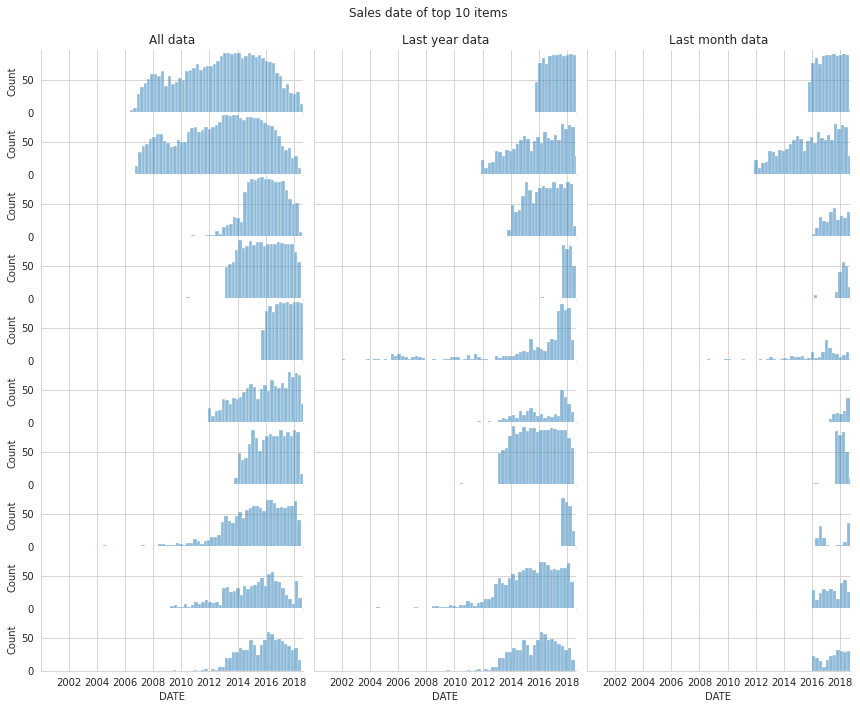

In [9]:
# Distribution of product sales 
item_purchased_count = ratings_trainings.groupby(by = 'asin')[['reviewerID']].count()

# All top 10 items 
top10_items_lst = item_purchased_count.reset_index().sort_values('reviewerID', ascending = False).head(10).asin.tolist()
top10_items = ratings_trainings[ratings_trainings.asin.isin(top10_items_lst)]
# sort by sales
top10_items = top10_items.set_index('asin').loc[top10_items_lst].reset_index()
top10_items.head()

# last year top 10 items 
item_purchased_count_year = ratings_trainings[ratings_trainings.DATE >= '2017-09-01'].\
    groupby(by = 'asin')[['reviewerID']].count()

top10_items_year_lst = item_purchased_count_year.reset_index().sort_values('reviewerID', ascending = False).head(10).asin.tolist()
top10_items_year = ratings_trainings[ratings_trainings.asin.isin(top10_items_year_lst)]
# sort by sales
top10_items_year = top10_items_year.set_index('asin').loc[top10_items_year_lst].reset_index()
top10_items_year.head()

# last month top 10 items 
item_purchased_count_month = ratings_trainings[ratings_trainings.DATE >= '2018-08-01'].\
    groupby(by = 'asin')[['reviewerID']].count()

top10_items_month_lst = item_purchased_count_month.reset_index().sort_values('reviewerID', ascending = False).head(10).asin.tolist()
top10_items_month = ratings_trainings[ratings_trainings.asin.isin(top10_items_month_lst)]
# sort by sales
top10_items_month = top10_items_month.set_index('asin').loc[top10_items_month_lst].reset_index()
top10_items_month.head()

fig, axs = plt.subplots(10, 3, sharex = True, sharey = True, figsize = (12, 10))
d = top10_items.groupby(['asin', 'DATE']).count().reset_index()
for i, a in enumerate(top10_items.asin.unique()):
    sns.histplot(data = d[d.asin == a], 
                x = 'DATE', hue = 'asin', palette = 'tab20', 
                legend = False, binwidth = (90), ax = axs[i, 0]
)

d_year = top10_items_year.groupby(['asin', 'DATE']).count().reset_index()
for i, a in enumerate(top10_items_year.asin.unique()):
    sns.histplot(data = d_year[d_year.asin == a], 
                x = 'DATE', hue = 'asin', palette = 'tab20', 
                legend = False, binwidth = (90), ax = axs[i, 1]
)

d_month = top10_items_month.groupby(['asin', 'DATE']).count().reset_index()
for i, a in enumerate(top10_items_month.asin.unique()):
    sns.histplot(data = d_month[d_month.asin == a], 
                x = 'DATE', hue = 'asin', palette = 'tab20', 
                legend = False, binwidth = (90), ax = axs[i, 2]
)

plt.tight_layout()
plt.suptitle('Sales date of top 10 items')
axs[0, 0].set_title('All data')
axs[0, 1].set_title('Last year data')
axs[0, 2].set_title('Last month data')
fig.subplots_adjust(top = 0.92, hspace=-.01)
sns.despine()

plt.xlim(datetime.datetime(2000,1,10), datetime.datetime(2018,9,1))

## Step5. Rule-based Recommendation Algorithm Implementation


*   Rule1: Based on the past year top10 popular products (highest numbers of the customers' comment and the highest rating scores)
*   Rule2: Multiple rules added to this algorithm


  1.   If the historical purchasements exists, based on that specific purchased items, we can refer `also_view`, `also_buy` and `same_brand`. 
  2.   20% of the remaining are recommended from the highest rankings.
  3.   Others are composed of the most popular items.





In [15]:
#Rule1: A year-based recommendation
def recommender_rule1(training_data, users=[], k=10):
    '''
    * training_data: dataframe 輸入的訓練資料集（2018-09-01 以前資料）
    * users: [] 需要被推薦的使用者
    * k: int 每個使用者需要推薦的商品數
    * recommendations: dict
      {
          使用者一： [推薦商品一, 推薦商品二, ...],
          使用者二： [...], ...
      }
    '''
    recommendations = {}
    ## Best seller (by rating data) & highest rating products (recommend `k` product)
    products_rating = training_data[training_data.DATE >= '2017-09-01'].groupby('asin')[['overall']].agg(['mean', 'count'])
    products_rating.columns = products_rating.columns.droplevel(0)
    best_seller_lst = products_rating.sort_values(by = ['count', 'mean'], ascending = False).index.tolist()[:k]

    recommendations = {user: best_seller_lst for user in users}
    return recommendations

rcListRule1 = recommender_rule1(ratings_trainings, users)

In [16]:
#Rule2: A year-based recommendation
def recommender_rule2(training_data, users=[], k=10):
    '''
    * training_data: dataframe 輸入的訓練資料集（2018-09-01 以前資料）
    * users: [] 需要被推薦的使用者
    * k: int 每個使用者需要推薦的商品數
    * recommendations: dict
      {
          使用者一： [推薦商品一, 推薦商品二, ...],
          使用者二： [...], ...
      }
    '''
    training_data = training_data[training_data.DATE >= '2017-09-01'].copy()
    recommendations = {}

    ## Highest rank
    highest_ranking_lst = metadata_clean.sort_values(by = 'rank_num')['asin'].tolist()

    ## Excluding lowest rating products 
    products_rating = training_data.groupby('asin')[['overall']].agg(['mean', 'count'])
    products_rating.columns = products_rating.columns.droplevel(0)
    lowest_rating_lst = products_rating[products_rating['mean'] < 3].index.tolist()

    ## Best seller (by rating data) & highest rating products
    best_seller_lst = products_rating.reset_index().sort_values(by = ['count', 'mean'], ascending = False)['asin'].tolist()

    for u in users:
        # purchased before
        user_recom = []
        # if the user already have historical purchasement
        if u in training_data['reviewerID'].values:
            
            # recommend `k1` products
            k1 = min(sum(training_data.reviewerID == u) * 3, 5)
            items_purchase = training_data.loc[training_data.reviewerID == u, 'asin'].values
            
            for i in items_purchase:

                # item i's `also_buy` 
                also_buy_lst = metadata_clean.loc[metadata_clean.asin == i, 'also_buy'].values[0]
                user_recom += also_buy_lst
                
                # item i's `also_view`
                also_view_lst = metadata_clean.loc[metadata_clean.asin == i, 'also_view'].values[0]
                user_recom += also_view_lst
                
                # items that other users who review item i also review (by rating data)
                also_review_users_lst = training_data.loc[(training_data.asin == i) & (training_data.reviewerID != u), 'reviewerID'].unique()
                also_review_items_lst = training_data.loc[(training_data.reviewerID.isin(also_review_users_lst)) & (training_data.asin != i), 'asin'].tolist()
                user_recom += also_review_items_lst

                # same brand 
                item_brand = metadata_clean.loc[metadata_clean.asin == i, 'brand'].values[0]
                # print(item_brand)
                # print(pd.isnull(item_brand))
                if pd.isnull(item_brand):
                    smae_brand_lst = metadata_clean.loc[metadata_clean.brand == item_brand, 'asin'].tolist()
                    user_recom += smae_brand_lst

                # at most k1 items from purchase history
                user_recom = user_recom[:k1]
        else:
            k1 = 0
        
        # Popular products (recommend `k_left` products)
        k_left = k - len(user_recom)
        k2 = round(k_left * 0.2)

        # concat all the item lists (k2 by rank, k3 by rating, others by sales)
        user_recom = user_recom + highest_ranking_lst[:k2] + best_seller_lst
        
        user_recom_k = []
        for p in user_recom:
            if p not in lowest_rating_lst:
                user_recom_k.append(p)
                if len(user_recom_k) >= 10:
                    break
        # user_recom = [i for i in user_recom if i not in lowest_rating_lst][:k]
        recommendations[u] = user_recom_k
    
    return recommendations


rcListRule2 = recommender_rule2(ratings_trainings, users)

## Step6. Evaluations

In [18]:
def evaluate(ratings_testings_by_user={}, ratings_by_user={}, method=None):
    '''
    * ratings_testings_by_user: dict 真實被購買的商品資料（2018-09-01 以後資料）
    * ratings_by_user: dict 利用訓練資料學習的推薦商品
    * method: str
    * score: float
    '''
    total = 0
    for d in ratings_testings_by_user:
        if d in ratings_by_user:
            total += len(set(ratings_by_user[d]) & set(ratings_testings_by_user[d]))

    score = total / len(ratings_testings)
    return score

# Rule1: A year-based recommendation
print(f'Rule1: \n{round(evaluate(ratings_testings_by_user, rcListRule1), 4)}')
print(f'Rule2: \n{round(evaluate(ratings_testings_by_user, rcListRule2), 4)}')

Rule1: 
0.0983
Rule2: 
0.0983
